<div class="alert alert-block alert-info">
<b><big><big><big>Consumption Estimation</b> <br>

In [7]:
%reset -f

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pickle
from datetime import datetime
from scipy.signal import savgol_filter
from scipy.signal import correlate
from sklearn.metrics import mean_squared_error
from IPython.core.magic import register_cell_magic
import random

from VehModel import CreateVehicle
from Mot_Pwr import estimate_mot_pwr

In [9]:
################################################################################################
# Specify Data Locations:
parquet_folder = '/home/sieglew/data/processed'                 # Volts Database
new_parquet_folder = '/home/sieglew/data/processed_2'           # same, but with modified time series data

volts_stats = '/home/sieglew/data/Volts.pickle'                 # list of volts Data files (from Parquet_Stats.ipynb)
pickle_destination_folder = '/home/sieglew/data/TripFiles'      # Trip pickles for Vehicle Model

y_true_folder = '/home/sieglew/data/y_true'                     # Energy Consumption Time Series Data
################################################################################################

In [10]:
@register_cell_magic
def skip(line, cell):   # cells can be skipped by using '%%skip' in the first line
    return

___
### **Import**

In [11]:
# import database statistics and complete list of files:
with open(volts_stats, 'rb') as handle:
    all_files, _, _, _ = pickle.load(handle) 

#files_list = [f for f in listdir(new_parquet_folder) if (isfile(join(new_parquet_folder, f)) and f.endswith(".parquet"))]

FileNotFoundError: [Errno 2] No such file or directory: '/home/sieglew/data/Volts.pickle'

In [ ]:
# either randomly choose trip file samples:
sample = random.sample(all_files,10)

# or specify trip name from parquet folder
sample = ["v_id983V14_trip133_2.parquet"]

In [ ]:
for f in sample:

    file_code = f[7:-8]
    with open(f'{pickle_destination_folder}/{file_code}.pickle', 'rb') as handle:
        T,C,V_prm = pickle.load(handle) 

    df = pd.read_parquet(parquet_folder + "/" + f, engine='fastparquet', columns = ["emot_pwr_cval"] )
    print(f)

    P_mot = estimate_mot_pwr(T.speed, 
                        T.accel, 
                        T.alt, 
                        T.road_grad, 
                        T.amb_temp, 
                        T.vehweight, 
                        V_prm["c_w_a"], 
                        V_prm["tire_roll_res_coeff"], 
                        rot_inertia = 0, 
                        eta_mech = 0.97,
                        eta_mot = 0.88
                        )

    fig , axs = plt.subplots(1, sharex=True,figsize=(18, 4)) #gridspec_kw={'hspace': 0}
    #plt.suptitle('Simulated and Measured Power of E-Motors', fontsize='16')
    axs.set_ylabel('Power in kW', fontsize='12')
    axs.plot(savgol_filter(df.emot_pwr_cval, 10, 3), label="emot_pwr_cval")
    axs.plot(savgol_filter(P_mot, 10, 3), label="emot_pwr_calculated")
    #axs.plot(df.emot_pwr_cval - P_mot, label="diff")
    axs.legend(loc="upper left")
    #axs.set_xlim([24000,25000])


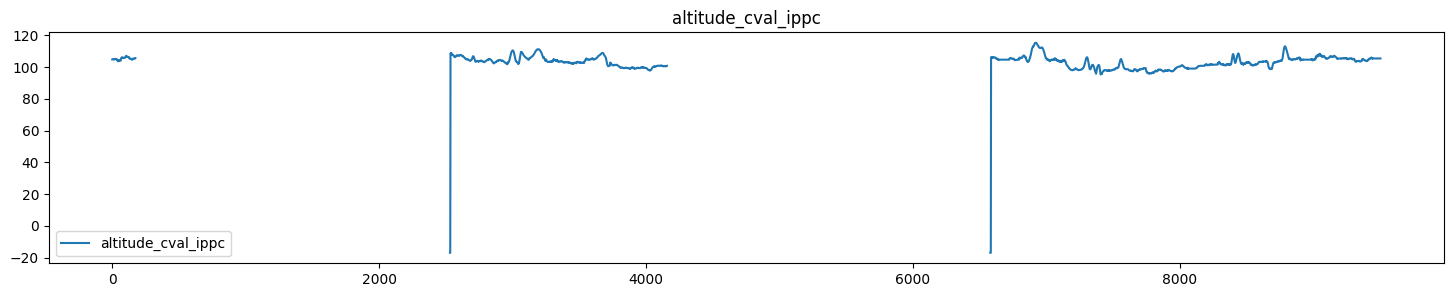

In [13]:
file = 'V13_trip207_2'
signal = "altitude_cval_ippc"
df = pd.read_parquet("/home/sieglew/data/processed/v_id983"+file+".parquet")
df.sort_index(axis=1, inplace=True)
_ = pd.DataFrame(pd.read_parquet("/home/sieglew/data/processed/v_id983"+file+".parquet")[signal]).plot(figsize=(18, 3), subplots=False, title = signal)

In [14]:
df = pd.read_parquet("/home/sieglew/data/EnergyConsumptions/V13_trip207_2.parquet")
_ = df.plot(figsize=(18, 3), subplots=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sieglew/data/EnergyConsumptions/V13_trip207_2.parquet'

In [ ]:
np.mean(W["vehweight"])

In [7]:
mean_squared_error(P_mech, T.Mot_pwr)

1907.3224562984728

In [ ]:

#P_mech = savgol_filter(P_mech, 10, 3)

In [14]:
# cumulated drivetrain Energy over time:
En_drv = np.cumsum(P_mech) / 3600  #[kWh]

In [15]:
Mot_pwr = savgol_filter(T.Mot_pwr, 10, 3)
En_Mot = np.cumsum(T.Mot_pwr)/3600

>Caculate Cumulated Vehicle Consumption in dependence of driving resistances

In [ ]:
fig, axs = plt.subplots(1, sharex=True,figsize=(18, 3)) #gridspec_kw={'hspace': 0}
plt.suptitle('Simulated and Measured Power of EMotors', fontsize='16')

axs.set_ylabel('Power [kW]', fontsize='12')
axs.plot(P_mech, label="Calculated Motor Power")
axs.plot(T.Mot_pwr, label="Emot_Pwr_Cval")
axs.legend(loc="lower left")
#axs.set_xlim([3950, 5380])

In [ ]:
mean_squared_error(P_mech, T.Mot_pwr)

In [ ]:
fig, axs = plt.subplots(1, sharex=True,figsize=(18, 3)) #gridspec_kw={'hspace': 0}
plt.suptitle('Simulated and Measured Consumption of EMotors', fontsize='16')

axs.set_ylabel('Cumulated Energy [kWh]', fontsize='12')
axs.plot(En_drv, label="Prediction")
axs.plot(En_Mot, label="Real")
axs.legend(loc="lower left")

___
### **Vehicle Consumption**

In [ ]:
SOC_pred = (T.soc[0] - En_drv / (V_prm['hv_batt_total_capacity'] * C["soh"])) * 100
#SOC_norecup = (T.soc[0] - En_drv_norecup / (V_prm['hv_batt_total_capacity'] * C["soh"])) * 100

fig, axs = plt.subplots(2, sharex=True,figsize=(18, 8)) #gridspec_kw={'hspace': 0}
plt.suptitle('SOC Consumption', fontsize='16')

axs[0].set_ylabel('SOC [%]', fontsize='12')
axs[0].plot(SOC_pred, label="Prediction: Driving Forces")
#axs[0].plot(SOC_norecup, label="Prediction: Driving Forces without recuperation")
axs[0].plot(T.soc.values*100, label="hv_bat_soc_cval_bms1")
axs[0].legend(loc="lower left")


In [ ]:

axs[0].set_ylabel('Altitude [m]', fontsize='12')
axs[1].set_ylabel('Matrix Profile', fontsize='12')

_ = pd.DataFrame(SOC_pred).plot(figsize=(18, 3), subplots=False, title = 'Vehicle Drive Power [kW]')
_ = pd.DataFrame(T.soc).plot(figsize=(18, 3), subplots=False, title = 'Vehicle Drive Power [kW]')

In [ ]:
_ = pd.DataFrame(T.bat_mom_en).plot(figsize=(18, 3), subplots=True, title = 'Vehicle Drive Power [kW]')
_ = pd.DataFrame(T.soc/100*T.bat_mom_en[0]/(T.soc[0]/100) - T.bat_mom_en).plot(figsize=(18, 3), subplots=True, title = 'Vehicle Drive Power [kW]')

In [ ]:
T.bat_mom_en[0]/(T.soc[0]/100)

In [ ]:
len(P_drive)